In [91]:
import torch
from torch import nn
from torch import optim

import pandas as pd
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [92]:
class CustomDataset(Dataset):

    def __init__(self, dataframe: pd.DataFrame, feature_names: list, target_name: str):
        scaler = StandardScaler()
        X = scaler.fit_transform(dataframe[feature_names])
        X = torch.tensor(X, dtype=torch.float32)
        
        self.X = X.reshape(X.shape[0], 1, X.shape[1])
        self.y = torch.tensor(dataframe[target_name].values, dtype=torch.float32)
        
    def __len__(self) -> int:
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [93]:
class FullyConnectedNet(nn.Module):

    def __init__(self, in_size: int, hidden_size: list, out_size: int):
        super(FullyConnectedNet, self).__init__()

        self.Network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_size, hidden_size[0]),
            nn.ReLU(),
            nn.Dropout(0.2), # nn.Dropout1d
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size[1], hidden_size[2]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size[2], hidden_size[3]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size[3], out_size),
        )
    
    def forward(self, x):
        return self.Network(x)


In [94]:
df = pd.read_csv("data\df_01.csv", index_col=[0])
df = df.reset_index().drop(columns=['index'])

In [95]:
lithology_keys = {30000: 0,
                  65030: 1,
                  65000: 2,
                  80000: 3,
                  74000: 4,
                  70000: 5,
                  70032: 6,
                  88000: 7,
                  86000: 8,
                  99000: 9,
                  90000: 10,
                  93000: 11}

In [96]:
df['FORCE_2020_LITHOFACIES_LITHOLOGY'] = df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)

In [97]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_ecoded = encoder.fit_transform(df[['FORCE_2020_LITHOFACIES_LITHOLOGY']])
one_hot_df = pd.DataFrame(one_hot_ecoded, columns=encoder.get_feature_names_out())
df = pd.concat([df, one_hot_df], axis=1)

In [98]:
feature_names = ['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RMED', 'RDEP', 'RHOB',
                 'GR', 'NPHI', 'PEF', 'DTC', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'ROPA']

target_name = ['FORCE_2020_LITHOFACIES_LITHOLOGY_0', 'FORCE_2020_LITHOFACIES_LITHOLOGY_1', 
               'FORCE_2020_LITHOFACIES_LITHOLOGY_2', 'FORCE_2020_LITHOFACIES_LITHOLOGY_3',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_4', 'FORCE_2020_LITHOFACIES_LITHOLOGY_5',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_6', 'FORCE_2020_LITHOFACIES_LITHOLOGY_7', 
               'FORCE_2020_LITHOFACIES_LITHOLOGY_8', 'FORCE_2020_LITHOFACIES_LITHOLOGY_9',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_10']

In [99]:
# df_test = df.sample(frac=0.2)
# df_train = df.loc[~df.index.isin(df_test.index)]

In [100]:
dataset = CustomDataset(dataframe=df, feature_names=feature_names, target_name=target_name)

train_, test = data.random_split(dataset, [0.8, 0.2])
train, val = data.random_split(train_, [0.7, 0.3])

In [101]:
train_data = DataLoader(dataset=train, batch_size=64, shuffle=True)
val_data = DataLoader(dataset=val, batch_size=64, shuffle=True)
test_data = DataLoader(dataset=test, batch_size=64, shuffle=False)

In [102]:

# train_dataset = CustomDataset(dataframe=df_train, feature_names=feature_names, target_name=target_name)
# train_data = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, )

# test_dataset = CustomDataset(dataframe=df_test, feature_names=feature_names, target_name=target_name)
# test_data = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True, )

In [103]:
# train_dataset.y

In [104]:
# train_dataset.X.shape

In [105]:
# train_dataset.y.shape

In [106]:
# test_dataset.X.shape

In [107]:
# test_dataset.y.shape

In [108]:
len(target_name)

11

In [109]:
model = FullyConnectedNet(in_size=len(feature_names), hidden_size=[288, 144, 72, 36], out_size=len(target_name))
print(model)

FullyConnectedNet(
  (Network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=18, out_features=288, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=288, out_features=144, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=144, out_features=72, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.2, inplace=False)
    (10): Linear(in_features=72, out_features=36, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.2, inplace=False)
    (13): Linear(in_features=36, out_features=11, bias=True)
  )
)


In [110]:
optimizer = optim.Adam(params=model.parameters(), lr=0.01) # weight_decay=0.001
loss_function = nn.CrossEntropyLoss()

In [111]:
epochs = 15
best_loss = 1e10 # заведомо высокое значение
loss_val = []
loss_train = []

for e in range(epochs):
    model.train()
    loss_mean = 0
    lm_count = 0

    train_tqdm = tqdm(train_data, leave=False)
    for x_train, y_train in train_tqdm:
        predict = model(x_train)
        loss = loss_function(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        train_tqdm.set_description(f'Epoch [{e+1}/{epochs}], loss_mean={loss_mean:.3f} ')
    
    model.eval()
    Q_val = 0
    count_val = 0

    for x_val, y_val in val_data:
        with torch.no_grad():
            prediction = model(x_val)
            loss = loss_function(prediction, y_val)
            Q_val += loss.item()
            count_val += 1

    Q_val /= count_val

    loss_train.append(loss_mean)
    loss_val.append(Q_val)
    
    print(f' | loss_mean={loss_mean:.3f}, Q_val={Q_val:.3f}')




 | loss_mean=0.654, Q_val=0.505


 | loss_mean=0.569, Q_val=0.487


 | loss_mean=0.556, Q_val=0.447


 | loss_mean=0.542, Q_val=0.414


 | loss_mean=0.532, Q_val=0.436


 | loss_mean=0.537, Q_val=0.423


 | loss_mean=0.520, Q_val=0.397


 | loss_mean=0.535, Q_val=0.402


 | loss_mean=0.533, Q_val=0.424


 | loss_mean=0.548, Q_val=0.413


 | loss_mean=0.532, Q_val=0.422


 | loss_mean=0.552, Q_val=0.425


 | loss_mean=0.527, Q_val=0.401


 | loss_mean=0.526, Q_val=0.399


 | loss_mean=0.524, Q_val=0.397


In [112]:
Q = 0

In [113]:
model.eval()

FullyConnectedNet(
  (Network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=18, out_features=288, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=288, out_features=144, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=144, out_features=72, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.2, inplace=False)
    (10): Linear(in_features=72, out_features=36, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.2, inplace=False)
    (13): Linear(in_features=36, out_features=11, bias=True)
  )
)

In [115]:
predictions = []
tests = []
test_tqdm = tqdm(test_data, leave=True)
for x_test, y_test in test_tqdm:
    predict = model(x_test)
    predict = torch.argmax(predict, dim=1)
    y_test = torch.argmax(y_test, dim=1)
    predictions.extend(predict.cpu().detach().numpy().tolist())
    tests.extend(y_test.cpu().detach().numpy().tolist())
    Q += torch.sum(predict == y_test).item()

100%|██████████| 380/380 [00:02<00:00, 177.79it/s]


In [ ]:
Q /= len(test_data)
print(Q)

56.21052631578947


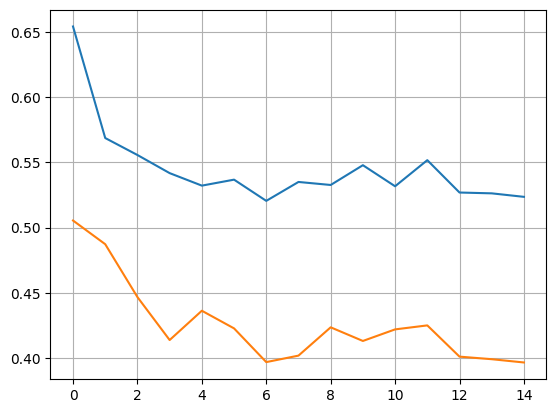

In [117]:
plt.plot(loss_train)
plt.plot(loss_val)
plt.grid()
plt.show()

In [118]:
from sklearn.metrics import confusion_matrix, classification_report

In [119]:
print(classification_report(tests, predictions))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2907
           1       0.74      0.59      0.66      2073
           2       0.90      0.97      0.94     13957
           3       0.84      0.57      0.68      1034
           4       0.21      0.39      0.27        44
           5       0.83      0.71      0.76      1759
           6       0.83      0.99      0.90       606
           7       0.99      1.00      0.99      1279
           8       0.68      0.12      0.20       112
           9       0.79      0.83      0.81       469
          10       0.00      0.00      0.00        44

    accuracy                           0.88     24284
   macro avg       0.70      0.64      0.64     24284
weighted avg       0.87      0.88      0.87     24284



c:\Users\tatya\Documents\well_log\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tatya\Documents\well_log\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tatya\Documents\well_log\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

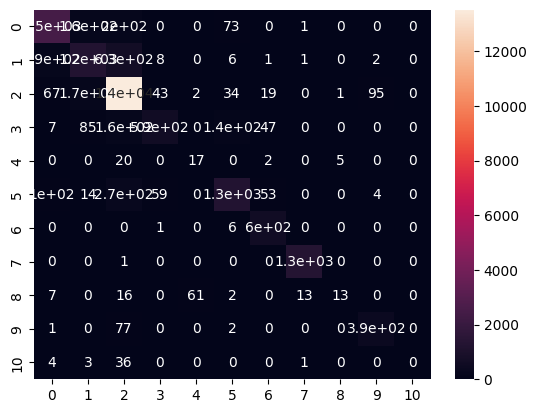

In [120]:
cm = confusion_matrix(tests, predictions)
sns.heatmap(cm, annot=True)

In [121]:
torch.save(model.state_dict(), 'models/fully_connected.tar')

In [122]:
model_2 = FullyConnectedNet(in_size=len(feature_names), hidden_size=[288, 144, 72, 36], out_size=len(target_name))
state_dict = torch.load('models/fully_connected.tar', weights_only=True)
model_2.load_state_dict(state_dict)

<All keys matched successfully>